In [37]:
import numpy as np
import pandas as pd
from datetime import datetime
import random
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score # AUC score
from sklearn.metrics import average_precision_score # AUPR score
from sklearn.metrics import precision_recall_fscore_support # precision, recall
from imblearn.metrics import sensitivity_specificity_support # sensitivity, specificity
from sklearn.metrics import roc_curve # to draw auc curve
from sklearn.metrics import precision_recall_curve # to draw aupr curve
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline

In [2]:
tra = pd.read_table("/DAS_Storage1/aschoi/data/Drug_Repositioning/8_new_training/2_similarity_based-PREDICT/2_3_gold_descriptor.tsv")
ind = pd.read_table("/DAS_Storage1/aschoi/data/Drug_Repositioning/8_new_training/2_similarity_based-PREDICT/3_2_indep_descriptor.tsv")

In [6]:
tra = tra[['drug_id', 'disease_id', 'association', 'drStr_diPhe', 'drPhe_diPhe']]

In [7]:
ind = ind[['drug_id', 'disease_id', 'association', 'drStr_diPhe', 'drPhe_diPhe']]

In [8]:
x_whole_data = tra[tra.columns.values[3:].tolist()].values
y_whole_data = tra["association"].values

In [19]:
indep_x = ind.values[:, 3:].astype(float)
indep_y = ind.values[:,2].astype(int)

In [40]:
# undersampler
#rus = RandomUnderSampler(ratio=0.3333) 1:3
rus = RandomUnderSampler(ratio=0.5) #1:2
rus = RandomUnderSampler(ratio=1.0) #1:2

In [41]:
x_resampled, y_resampled = rus.fit_sample(x_whole_data, y_whole_data)
Counter(y_resampled)

Counter({0: 1330, 1: 1330})

In [42]:
x_whole_data = x_resampled
y_whole_data = y_resampled

In [43]:
def plot_with_labels(low_dim_embs, labels, filename='temp.png'):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(10, 10))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        if label==1:
            plt.scatter(x, y, color="blue", alpha=1)
        else:
            plt.scatter(x, y, color="red", alpha=0.3)
    #plt.savefig("/home/share/aschoi/nas/users/asolchoi/"+filename)
    #plt.show()

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


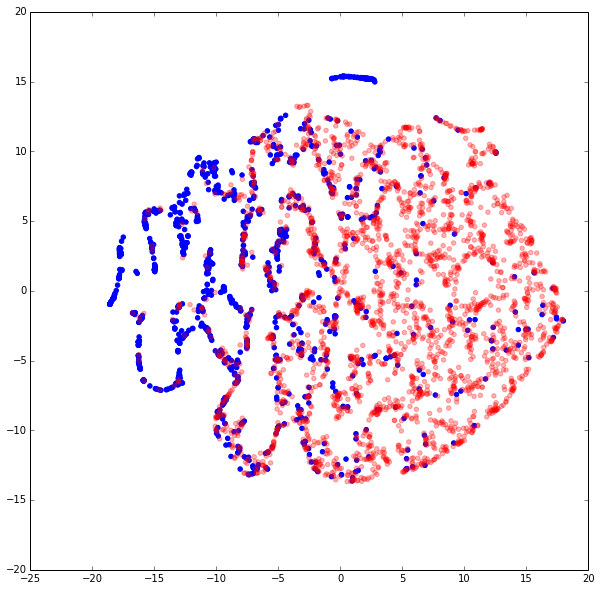

In [18]:
try:
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt
    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
    #plot_only = 1000
    low_dim_embs = tsne.fit_transform(x_whole_data)
    labels = y_whole_data
    plot_with_labels(low_dim_embs, labels, "3.random noise.png")
except ImportError:
    print("Please install sklearn, matplotlib, and scipy to visualize embeddings.")

2017-05-08 07:03:27
user_c = 0.0001 ended2017-05-08 07:03:31
user_c = 0.001 ended2017-05-08 07:03:35
user_c = 0.01 ended2017-05-08 07:03:39
user_c = 0.1 ended2017-05-08 07:03:43
user_c = 1 ended2017-05-08 07:03:45
user_c = 10 ended2017-05-08 07:03:48
user_c = 100 ended2017-05-08 07:03:51
user_c = 1000 ended2017-05-08 07:03:59
user_c = 10000 ended2017-05-08 07:04:25
0.0001------------------------------------


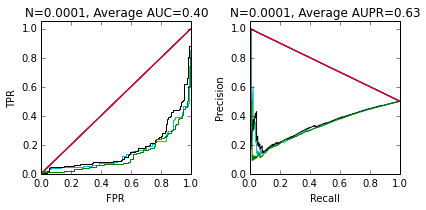

0.001------------------------------------


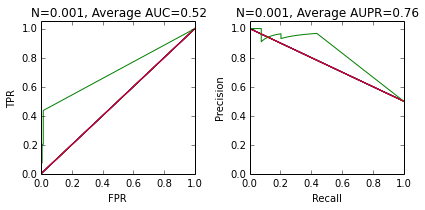

0.01------------------------------------


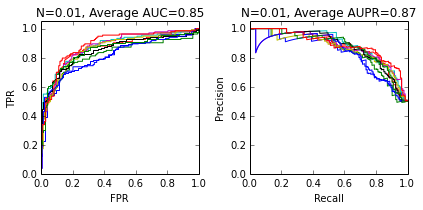

0.1------------------------------------


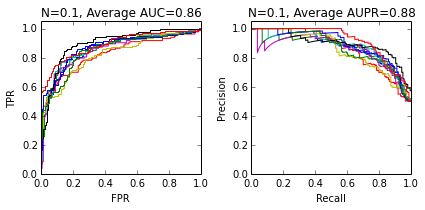

1------------------------------------


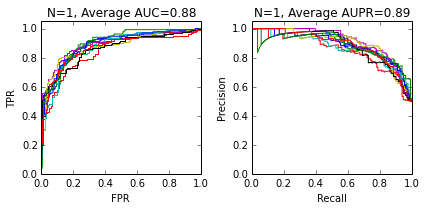

10------------------------------------


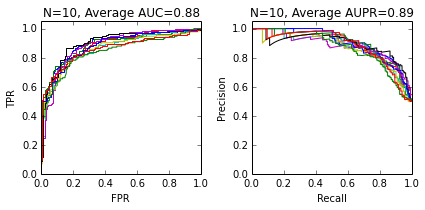

100------------------------------------


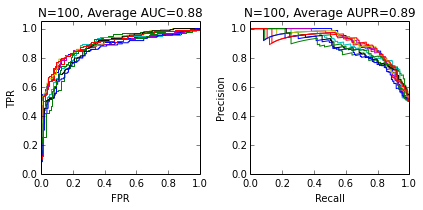

1000------------------------------------


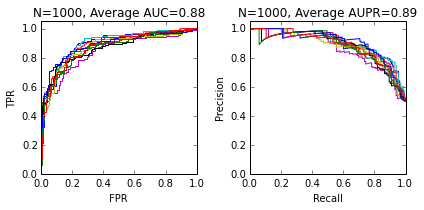

10000------------------------------------


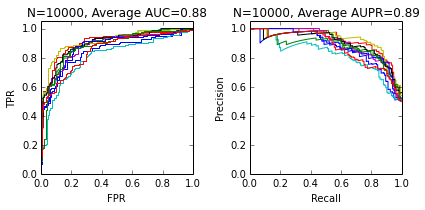

2017-05-08 07:04:27


In [44]:
# pick random noise by 1:1 herbal compounds (P:TN:Noise = 1:1:1 --> P:N = 1:2)
# SVM with quadratic Kernel
print datetime.now().strftime('%Y-%m-%d %H:%M:%S')
path = '/home/share/aschoi/nas/users/asolchoi/data/Drug_Repositioning/8_new_training/5_final/'
with open(path + "test_no_disgesim2.txt", 'w') as fd :
    param_results = {0.0001:[], 0.001:[], 0.01:[], 0.1:[], 1:[], 10:[], 100:[], 1000:[], 10000:[]}
    draw_total = {0.0001:[], 0.001:[], 0.01:[], 0.1:[], 1:[], 10:[], 100:[], 1000:[], 10000:[]}
    #independent_count = 1 # independent test 하고 싶은 횟수, 횟수만큼 랜덤 추출 하여 k-fold cv를 돌린다.
    k = 10
    params = {'k': k, 'kernel': 'poly', 'degree':2}
    #for i in range(independent_count):
        #x_resampled, y_resampled = rus.fit_sample(x_whole_data, y_whole_data)
    for user_c in [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]:
        params['user_c'] = user_c
        folds_results, draw_results = SVM_K_fold_graph(x_whole_data, y_whole_data, params)
        avg_result = average_result(folds_results) # parameter 별로 K-fold한 결과와 average를 구한다.
        param_results[user_c].append(avg_result) # parameter 별로 indepedent 결과 저장한다.
        draw_total[user_c].append(draw_results)
        print 'user_c = {} ended'.format(user_c) + datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    
    final_param_results = {0.0001:[], 0.001:[], 0.01:[], 0.1:[], 1:[], 10:[], 100:[], 1000:[], 10000:[]}
    for user_c in [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]: #independent 결과를 parameter별로 평균 낸다.
        indep_results = independent_results(param_results[user_c])
        final_param_results[user_c] = final_results(indep_results)
        draw_plot(draw_total[user_c], final_param_results[user_c], user_c)
        write_output(fd, final_param_results[user_c], user_c)
print datetime.now().strftime('%Y-%m-%d %H:%M:%S')

2017-05-08 07:05:31
100------------------------------------


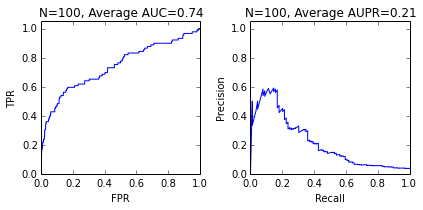

2017-05-08 07:05:32


In [45]:
#제일 좋은 파라미터 --> C = 10
# independent test in SVM with quadratic kernel
# pick random noise by 1:1 independent (P:TN:Noise = 1:1:1 --> P:N = 1:2)
print datetime.now().strftime('%Y-%m-%d %H:%M:%S')
path = '/home/share/aschoi/nas/users/asolchoi/data/Drug_Repositioning/8_new_training/5_final/'
with open(path + "test_no_disgesim_indep2.txt", 'w') as fd :
    user_c = 100
    params = {'kernel': 'poly', 'degree':2, 'user_c' : user_c}
    folds_results, draw_results, fp_results = SVM_independent_graph(x_whole_data, y_whole_data, indep_x, indep_y, params)
    draw_plot([draw_results], folds_results, user_c)
    write_output(fd, folds_results, user_c)
#li_noise1.append(predicted_results(fp_results))
print datetime.now().strftime('%Y-%m-%d %H:%M:%S')

In [33]:
def SVM_K_fold_graph(X, y, params):
       
    skf = StratifiedKFold(n_splits=params['k'], shuffle=True) # n_splits = k (k fold라서.), pos:neg의 비율을 고려해서 k 개의 subgroup으로 나누어줌.
    folds_results = {'acc':[], 'auc':[], 'aupr':[], 'confusion_matrix':[], 'sn':[], 'sp':[], 'precision':[], 'recall':[]}
    draw_results = {'fpr':[], 'tpr':[], 'precision_vec':[], 'recall_vec':[]}
    for training_index, validation_index in skf.split(X, y):
        x_training_set = X[training_index]
        y_training_set = y[training_index]
        x_validation_set = X[validation_index]
        y_validation_set = y[validation_index]
        
        classifier = SVC(C=params['user_c'], cache_size=1000, kernel = params['kernel'], degree = params['degree'], probability=True) #n_jobs=-1 이면 모든 node 쓰는것, 신경쓰이면 30개 정도.
        classifier.fit(x_training_set, y_training_set)
        
        y_predicted_proba = classifier.predict_proba(x_validation_set) # [0에 대한 확률, 1에 대한 확률], shpae = [n_samples, n_class]
        y_predicted_label = classifier.predict(x_validation_set) # 예측된 label을 보여줌, shpae = [n_samples]
        
        # Accuracy 
        current_acc = classifier.score(x_validation_set, y_validation_set)
        folds_results['acc'].append(current_acc)

        # AUC
        current_auc = roc_auc_score(y_validation_set, y_predicted_proba[:,1])
        folds_results['auc'].append(current_auc)
        
        # Sensitivity, Specificity
        sn, sp, support = sensitivity_specificity_support(y_validation_set, y_predicted_label)
        folds_results['sn'].append(sn)
        folds_results['sp'].append(sp)
        
        # AUPR
        current_aupr = average_precision_score(y_validation_set, y_predicted_proba[:,1])
        folds_results['aupr'].append(current_aupr)
        
        # Precision, Recall
        precision, recall, _, _ =  precision_recall_fscore_support(y_validation_set, y_predicted_label, average = 'binary')
        folds_results['precision'].append(precision)
        folds_results['recall'].append(recall)
        
        # Confusion Matrix
        current_confusion_matrix = confusion_matrix(y_validation_set,y_predicted_label)
        folds_results['confusion_matrix'].append(current_confusion_matrix)
        
        #draw graph
        fpr, tpr, thresholds = roc_curve(y_validation_set, y_predicted_proba[:, 1], pos_label=1)
        draw_results['fpr'].append(fpr)
        draw_results['tpr'].append(tpr)
        
        precision_vec, recall_vec, _ = precision_recall_curve(y_validation_set, y_predicted_proba[:, 1])
        draw_results['precision_vec'].append(precision_vec)
        draw_results['recall_vec'].append(recall_vec)
        
    return folds_results, draw_results

def final_results (indep_results):
    results = {'acc':[], 'auc':[], 'aupr':[], 'confusion_matrix':[],
               'sn':[], 'sp':[], 'precision':[], 'recall':[]}
    results['acc'] = sum(indep_results['indep_acc']) / len(indep_results['indep_acc'])
    results['auc'] = sum(indep_results['indep_auc']) / len(indep_results['indep_auc'])
    results['aupr'] = sum(indep_results['indep_aupr']) / len(indep_results['indep_aupr'])
    results['sn'] = sum(indep_results['indep_sn']) / len(indep_results['indep_sn'])
    results['sp'] = sum(indep_results['indep_sp']) / len(indep_results['indep_sp'])
    results['precision'] = sum(indep_results['indep_precision']) / len(indep_results['indep_precision'])
    results['recall'] = sum(indep_results['indep_recall']) / len(indep_results['indep_recall'])
    results['confusion_matrix'] = sum(indep_results['indep_confusion_matrix'])
    return results

def independent_results(param_result):
    indep_results = {'indep_acc':[], 'indep_auc':[], 'indep_aupr':[], 'indep_confusion_matrix':[],
                     'indep_sn':[], 'indep_sp':[], 'indep_precision':[], 'indep_recall':[]}
    for fold in param_result:
        indep_results['indep_acc'].append(fold['avg_acc'])
        indep_results['indep_auc'].append(fold['avg_auc'])
        indep_results['indep_aupr'].append(fold['avg_aupr'])
        indep_results['indep_sn'].append(fold['avg_sn'])
        indep_results['indep_sp'].append(fold['avg_sp'])
        indep_results['indep_precision'].append(fold['avg_precision'])
        indep_results['indep_recall'].append(fold['avg_recall'])
        indep_results['indep_confusion_matrix'].append(fold['sum_confusion_matrix'])
    return indep_results
def average_result(folds_results):
    avg_result = dict()
    avg_result['avg_acc'] = sum(folds_results['acc']) / len(folds_results['acc'])
    avg_result['avg_auc'] = sum(folds_results['auc']) / len(folds_results['auc'])
    avg_result['avg_aupr'] = sum(folds_results['aupr']) / len(folds_results['aupr'])
    avg_result['avg_sn'] = sum(folds_results['sn']) / len(folds_results['sn'])
    avg_result['avg_sp'] = sum(folds_results['sp']) / len(folds_results['sp'])
    avg_result['avg_precision'] = sum(folds_results['precision']) / len(folds_results['precision'])
    avg_result['avg_recall'] = sum(folds_results['recall']) / len(folds_results['recall'])
    avg_result['sum_confusion_matrix'] = sum(folds_results['confusion_matrix'])
    
    return avg_result
def draw_plot(draw_results, final_result, user_c):
    #colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange', 'red', 'violet', 'fuchsia', 'sienna'])
    colors = ['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange', 'red', 'violet', 'fuchsia', 'sienna']
    lw = 1
    plt.clf()
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))
    print "{}------------------------------------".format(user_c)
    for i in draw_results:
        for fpr, tpr in zip(i['fpr'], i['tpr']):
            ax1.plot(fpr, tpr, lw=lw)
        for recall_vec, precision_vec in zip(i['recall_vec'], i['precision_vec']):
            ax2.plot(recall_vec, precision_vec, lw=lw)
    ax1.set_xlabel('FPR')
    ax1.set_ylabel('TPR')
    ax1.set_color_cycle(colors)
    ax1.set_title('N={0}, Average AUC={1:0.2f}'.format(user_c, final_result['auc']))
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlim([0.0, 1.0])
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_color_cycle(colors)
    ax2.set_title('N={0}, Average AUPR={1:0.2f}'.format(user_c, final_result['aupr']))
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlim([0.0, 1.0])
    plt.tight_layout()
    plt.show()
def write_output(fd, write_results, user_c):
    fd.write("user_c={}-------------------------------------------------\r\n".format(user_c))
    fd.write("Accuracy avg : {}\r\n".format(write_results['acc']))
    fd.write("AUC avg : {}\r\n".format(write_results['auc']))
    fd.write("  Sensitivity avg : {}\r\n".format(write_results['sn']))
    fd.write("  Specificity avg : {}\r\n".format(write_results['sp']))
    fd.write("AUPR avg : {}\r\n".format(write_results['aupr']))
    fd.write("  Precision avg : {}\r\n".format(write_results['precision']))
    fd.write("  Recall avg : {}\r\n".format(write_results['recall']))
    fd.write("confusion amtrix : {}\r\n".format(write_results['confusion_matrix']))

In [34]:
def SVM_independent_graph(X, y, indep_X, indep_y, params):

    folds_results = dict()
    draw_results = {'fpr':[], 'tpr':[], 'precision_vec':[], 'recall_vec':[]}
    fp_results = dict()
    
    classifier = SVC(C=params['user_c'], cache_size=1000, kernel = params['kernel'], degree = params['degree'], probability=True)
    classifier.fit(X, y)
    indep_y_predicted_proba = classifier.predict_proba(indep_X)
    indep_y_predicted_label = classifier.predict(indep_X)
    fp_results['predicted_proba'] = indep_y_predicted_proba
    fp_results['Predicted_label'] = indep_y_predicted_label
    fp_results['y_true'] = indep_y

    # Accuracy
    indep_acc = classifier.score(indep_X, indep_y)
    folds_results['acc']=indep_acc
    
    # AUC
    indep_auc = roc_auc_score(indep_y, indep_y_predicted_proba[:,1])
    folds_results['auc']=indep_auc
    
    # Sensitivity, Specificity
    indep_sn, indep_sp, support = sensitivity_specificity_support(indep_y, indep_y_predicted_label)
    folds_results['sn']=indep_sn
    folds_results['sp']=indep_sp
    
    # AUPR
    indep_aupr = average_precision_score(indep_y, indep_y_predicted_proba[:,1])
    folds_results['aupr']=indep_aupr
    
    # Precision, Recall
    indep_precision, indep_recall, _, _ = precision_recall_fscore_support(indep_y, indep_y_predicted_label, average = 'binary')
    folds_results['precision']=indep_precision
    folds_results['recall']=indep_recall
    
    # Confusion Matirx
    indep_confusion_matirx = confusion_matrix(indep_y, indep_y_predicted_label)
    folds_results['confusion_matrix']=indep_confusion_matirx
    
    # draw graph
    indep_fpr, indep_tpr, thresholds = roc_curve(indep_y, indep_y_predicted_proba[:, 1], pos_label=1)
    draw_results['fpr'].append(indep_fpr)
    draw_results['tpr'].append(indep_tpr)
        
    indep_precision_vec, indep_recall_vec, _ = precision_recall_curve(indep_y, indep_y_predicted_proba[:, 1])
    draw_results['precision_vec'].append(indep_precision_vec)
    draw_results['recall_vec'].append(indep_recall_vec)

    return folds_results, draw_results, fp_results

'''def draw_plot(draw_results, final_result, i, user_c):
    #colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange', 'red', 'violet', 'fuchsia', 'sienna'])
    colors = ['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange', 'red', 'violet', 'fuchsia', 'sienna']
    lw = 1
    plt.clf()
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))
    print "{} : {}------------------------------------".format(i, user_c)
    for i in draw_results:
        for fpr, tpr in zip(i['fpr'], i['tpr']):
            ax1.plot(fpr, tpr, lw=lw)
        for recall_vec, precision_vec in zip(i['recall_vec'], i['precision_vec']):
            ax2.plot(recall_vec, precision_vec, lw=lw)
    ax1.set_xlabel('FPR')
    ax1.set_ylabel('TPR')
    ax1.set_color_cycle(colors)
    ax1.set_title('N={0}, Average AUC={1:0.2f}'.format(user_c, final_result['auc']))
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlim([0.0, 1.0])
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_color_cycle(colors)
    ax2.set_title('N={0}, Average AUPR={1:0.2f}'.format(user_c, final_result['aupr']))
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlim([0.0, 1.0])
    plt.tight_layout()
    plt.show()'''
    
'''def write_output(fd, write_results, i, user_c):
    fd.write("try={}, N={}-------------------------------------------------\r\n".format(i, user_c))
    fd.write("Accuracy avg : {}\r\n".format(write_results['acc']))
    fd.write("AUC avg : {}\r\n".format(write_results['auc']))
    fd.write("  Sensitivity avg : {}\r\n".format(write_results['sn']))
    fd.write("  Specificity avg : {}\r\n".format(write_results['sp']))
    fd.write("AUPR avg : {}\r\n".format(write_results['aupr']))
    fd.write("  Precision avg : {}\r\n".format(write_results['precision']))
    fd.write("  Recall avg : {}\r\n".format(write_results['recall']))
    fd.write("confusion amtrix : {}\r\n".format(write_results['confusion_matrix']))'''

'def write_output(fd, write_results, i, user_c):\n    fd.write("try={}, N={}-------------------------------------------------\r\n".format(i, user_c))\n    fd.write("Accuracy avg : {}\r\n".format(write_results[\'acc\']))\n    fd.write("AUC avg : {}\r\n".format(write_results[\'auc\']))\n    fd.write("  Sensitivity avg : {}\r\n".format(write_results[\'sn\']))\n    fd.write("  Specificity avg : {}\r\n".format(write_results[\'sp\']))\n    fd.write("AUPR avg : {}\r\n".format(write_results[\'aupr\']))\n    fd.write("  Precision avg : {}\r\n".format(write_results[\'precision\']))\n    fd.write("  Recall avg : {}\r\n".format(write_results[\'recall\']))\n    fd.write("confusion amtrix : {}\r\n".format(write_results[\'confusion_matrix\']))'